# Рекомендация тарифов оператора мобильной связи

## 1. Получение данных

Импорт библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

Откроем файл users_behavior.csv, сохраним его в переменной `df` и посмотрим первые 5 строк таблицы.

In [2]:
df = pd.read_csv('users_behavior.csv')

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Посмотрим общую информацию о данных таблицы `df`.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Всего в таблице 5 столбцов.
Разберём, какие в `df` столбцы и какую информацию они содержат:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Посмотрим общую информацию о датафрейме.

In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Построим гистограммы и посмотрим на распределение данных.

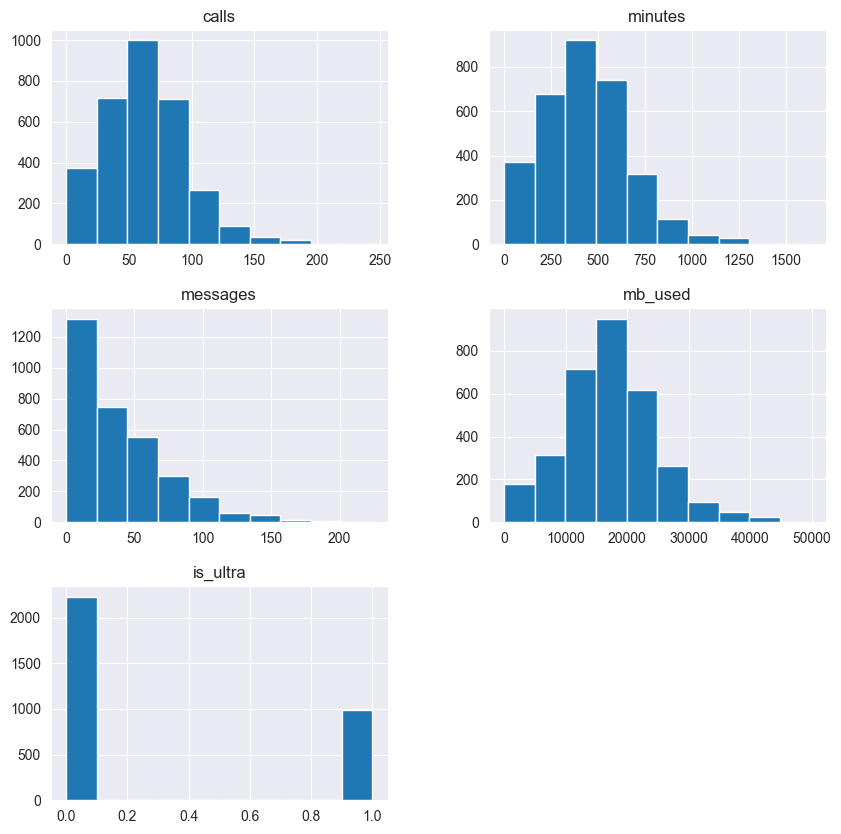

In [5]:
df.hist(figsize=(10, 10));

Посмотрим, присутствует ли в данных мультиколлинеарность.

In [6]:
df.corr(method='spearman')

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.978684,0.155032,0.253886,0.160549
minutes,0.978684,1.000000,0.153784,0.248818,0.159991
messages,0.155032,0.153784,1.000000,0.141999,0.106537
mb_used,0.253886,0.248818,0.141999,1.000000,0.154989
is_ultra,0.160549,0.159991,0.106537,0.154989,1.000000


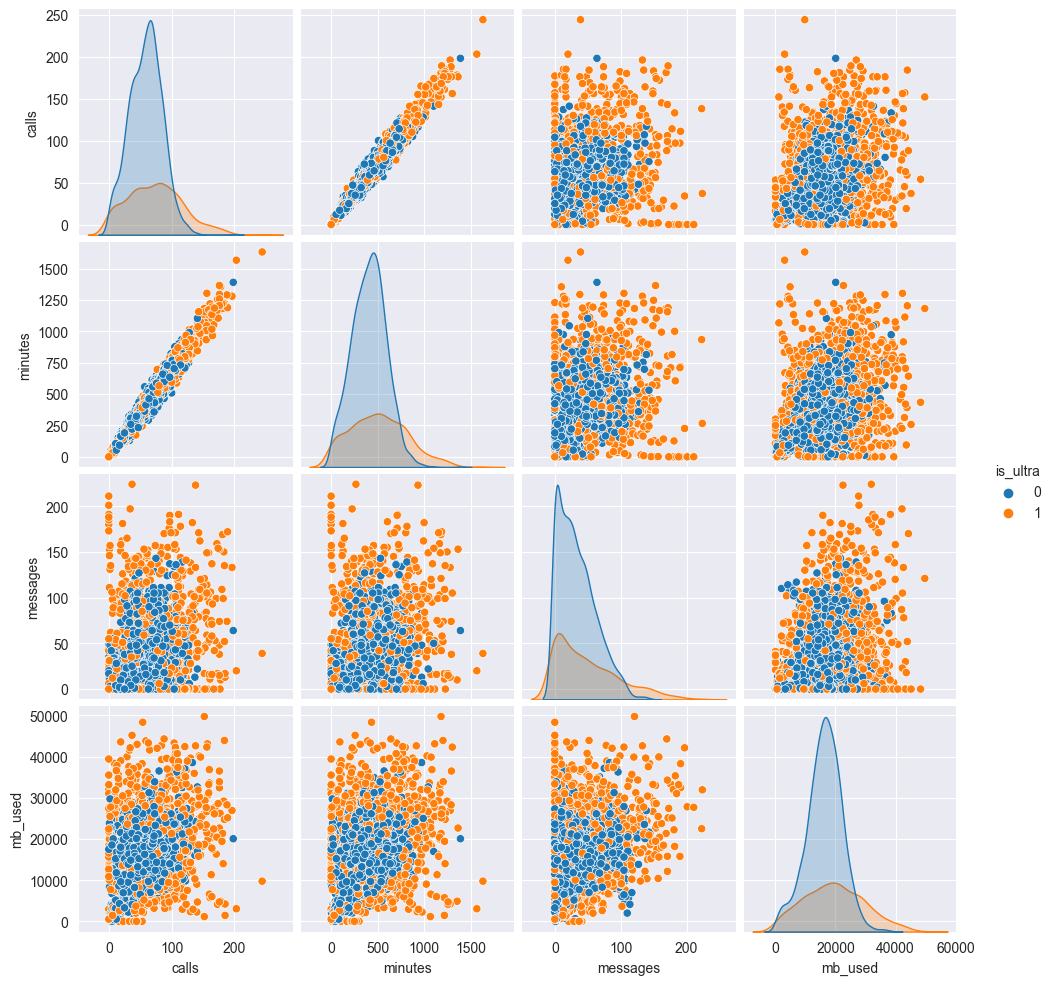

In [ ]:
sns.pairplot(df, hue='is_ultra');

### Вывод

Первое представление о данных получено. Можно сделать следующие выводы:
- В таблице 5 столбцов и 3214 строк.
- Пропуски отсутствуют. Предобработкак данных, согласно условию задачи, не треббуется.
- В наших данных есть мультиколлинеарность в фичах `calls` и `minutes`. В нашем проекте мы сосредоточены на предсказаниях, поэтому проблема мультиколлинеарности, если она и есть, для нас не страшна, на предсказаниях она не сказывается, для скоррелированных признаков они смещены, поэтому их интерпретация становится невозможной, но для нас в данном проекте это не имеет значения.

## 2. Разделение данных на выборки

Разделим исходные данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

**Признаки:** `calls`, `minutes`, `messages`, `mb_used`.

**Целевой признак:** `is_ultra`

In [ ]:
df_train, df_test_and_valid = train_test_split(df, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_test_and_valid, test_size=0.5, random_state=12345)
print('Размер обучающей выборки:', len(df_train))
print('Размер валидационной выборки:', len(df_valid))
print('Размер тестовой выборки:', len(df_test))

Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


Разделим выборки на целевой признак и фичи.

In [ ]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

### Вывод

Исходные данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. В каждой выборке выделен целевой признак (`is_ultra`). 

## 3. Обучение моделей

Перед нами стоит задача классификации, для решения задачи будет использовать следующие модели:
- Решающее дерево;
- Случайный лес;
- Логистическая регрессия.

Для оценки качества моделей будем использовать метрику `accuracy`. Согласно условию задачи, доля правильных ответов должна составлять не менее 0.75.

### Решающее дерево

In [10]:
best_model = None
best_result = 0
best_depth = 0
for depth in range(1, 6):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    predictions_valid = model_dt.predict(features_valid)
    result = model_dt.score(features_valid, target_valid)
    if result > best_result:
        best_model = model_dt
        best_result = result
        best_depth = depth

print('Accuracy наилучшей модели на валидационной выборке:', best_result)
print('Глубина дерева:', best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7853810264385692
Глубина дерева: 3


### Случайный лес

In [11]:
best_model = None
best_result = 0
for depth in range(1, 10):
    for est in range(10, 100, 10):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_rf.fit(features_train, target_train)
        result = model_rf.score(features_valid, target_valid)
        if result > best_result:
            best_model = model_rf
            best_result = result
            best_est = est
            best_depth = depth

print('Accuracy наилучшей модели на валидационной выборке:', best_result)
print('Количество деревьев:', best_est)
print('Глубина дерева:', best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8087091757387247
Количество деревьев: 40
Глубина дерева: 8


### Логистическая регрессия

In [12]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train) 
result = model_lr.score(features_valid, target_valid)
print("Accuracy наилучшей модели на валидационной выборке:", result)

Accuracy наилучшей модели на валидационной выборке: 0.7107309486780715


### Вывод

Мы обучили различные модели и оценили их качество на валидационной выборке. Наилучшие результаты для каждой модели:

**Решающее дерево:**
- глубина дерева: 3
- точность на валидационной выборке: 0.785

**Случайный лес:**
- количество деревьев: 40
- глубина дерева: 8
- точность на валидационной выборке: 0.809

**Логистическая регрессия:**
- точность на валидационной выборке: 0.711

Наилучшая модель: случайный лес. У данной модели наиболее высокая точность.

## 4. Тестирование модели

Так как наиболее точной моделью оказался случайный лес, проверим данную модель на тестовой выборке.

In [13]:
model = RandomForestClassifier(random_state=12345, n_estimators=40, max_depth=8)
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)
test_result = accuracy_score(target_test, test_predictions)
print("Accuracy модели на тестовой выборке:", test_result)

Accuracy модели на тестовой выборке: 0.7962674961119751


### Проверка модели на адекватность.

Проверим модель на адекватность с помощью DummyClassifier. Если точность нашей модели будет выше, значит ее предсказания лучше рандомных.

In [14]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train) 
dummy_score = dummy.score(features_test, target_test)
print("Accuracy модели на тестовой выборке:", dummy_score)

Accuracy модели на тестовой выборке: 0.6842923794712286


### Вывод

Мы проверили качество модели на тестовой выборке. Доля правильных ответов модели: 0.796, что превышает показатель 0.75.

Наша модель также прошла проверку на адекватность. Точность рандомной модели ниже, чем у модели случайного леса.

## Общий вывод

Были загружены и проанализированы данные оператора мобильной связи «Мегалайн».
Исходные данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. В каждой выборке выделен целевой признак (`is_ultra`).

Были обучены различные модели, оценено их качество на валидационной выборке, подобрана лучшая модель и параметры дня нее.
- Наилучшую точность показала модель `RandomForestClassifier` - 0.809. (лучший результат достигается при гиперпараметрах n_estimators=40 и max_depth=8).
- Чуть ниже точность у модели `DecisionTreeClassifier` - 0.785 (max_depth=3).
- Самый плохой показатель у модели `LogisticRegression` - 0.711.

Мы проверили нашу модель на тестовых данных, полученные результаты (`accuracy` = 0.796) оказались близки к данным на валидационной выборке (`accuracy` = 0.809). 

Также мы проверили модель на адекватность, наша модель показывает более точные результаты в сравнении со случайными предсказаниями.

Данная модель дает довольно точные предсказания, поэтому поможет заказчику перевести большое количество клиентов с архивных тарифов на новые, более выгодные.